# Libraries

In [1]:
import gym
import matplotlib.pyplot as plt
from pyswip import Prolog
from utils import process_state, perform_action,extract_monsters, set_health, check_death, display_inventory
from nle import nethack
from utilsbattle import get_money_location, get_stair_location, get_target_location, get_reference_des
import numpy as np
import run 
import json

# Simulation parameters

In [2]:
NUM_EPISODES = 5
MAX_STEPS = 100
PATH = 'kb.pl'
RISK_THRESHOLD=50# when the agent feels it's not healthy anymore
MONEY_THRESHOLD=1
MONEY=20
ARROWS= 2
ARROWS_THRESHOLD=4

Initialize the knowledge base.

In [3]:
KB = Prolog()
KB.consult(PATH)

#KB.consult(BATTLE_PATH)


#loading initial agent paramters into the knowledge base
#KB.asserta(f"health_threshold({RISK_THRESHOLD})")
#KB.asserta(f"money_threshold({MONEY_THRESHOLD})")
#KB.asserta(f"money({MONEY})")
#KB.retractall('onPlan(_)')
#KB.asserta(f"arrows_threshold({ARROWS_THRESHOLD})")
#KB.asserta(f"arrows({ARROWS})")





#### Main code
- Perform `NUM_EPISODES` experiences in the environment.
- Use `Prolog` to define the axioms and choose the action to perform.
- The main goal is to _reach and eat_ the `apple`.

In [4]:
def vacuum_experiment(des_file,room_type,starting_money,starting_health = 18,starting_items=[],debug = False) :

    rewards = []
    action=None

    #ran=run.Run()
    for _ in range(1):

        #set agent parameters
        KB.asserta(f"health_threshold({RISK_THRESHOLD})")
        KB.asserta(f"money_threshold({MONEY_THRESHOLD})")
        KB.asserta(f"money({starting_money})")
        KB.retractall('onPlan(_)')
        KB.retractall('battle_begin')
        #des_file=ran.getdes()
        #room_type=ran.gettype()
        
        env = gym.make("MiniHack-Skill-Custom-v0",
                        character="Agent-cav-hum-neu-mal",
                        observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel','chars','inv_oclasses','glyphs'),
                        wizard = True,
                        max_episode_steps = MAX_STEPS ,
                        options =(
                            "color",  # Display color for different monsters, objects, etc
                            "showexp",  # Display the experience points on the status line
                            "nobones",  # Disallow saving and loading bones files
                            "nolegacy",  # Not display an introductory message when starting the game
                            "nocmdassist",  # No command assistance
                            "disclose:+i +a +v +g +c +o",  # End of game prompt replies
                            "runmode:teleport",  # Update the map after movement has finished
                            "mention_walls",  # Give feedback when walking against a wall
                            "nosparkle",  # Not display sparkly effect for resisted magical attacks
                            "showscore",  # Shows approximate accumulated score on the bottom line
                            "race:dwa","gender:mal","align:neu","role:cav",
                            "!autopickup",
                            "pettype:none",
                        ),
                        des_file=des_file,
                )
        obs=env.reset(wizkit_items = starting_items + ['20 scroll of fire','6 potion of confusion','unicorn horn'])
        if debug: display_inventory(obs['inv_strs'])
# elabora in base alle osservazioni presenti
        


        #env.render()
        #print(des_file)
        # count the number of steps of the current episode
        steps = 0
        # store the cumulative reward
        reward = 0.0
        # collect obs['pixel'] to visualize
        ep_states = []
        #agent starts in the shop
        in_battle = False
        #agent start with no plan for battle
        planned_actions = False
    

        #process level information
        
        if any(map(lambda x:x==room_type,['mazeroom','minibossroom'])):
            KB.asserta("corridors")
        monsters=extract_monsters(des_file)

        #compute the second closed door position
        goal_x,goal_y=-1,-1
        level_heigth=len(obs['screen_descriptions'])
        level_width=len(obs['screen_descriptions'][0])
        for i in range(level_heigth):
            for j in range(level_width):
                objs = bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')
                if 'closed door' in objs and i > goal_x:
                    goal_x,goal_y=i,j
        KB.asserta(f'battlefield_start({goal_x},{goal_y})')

        #print(f'battlefield_start({goal_x},{goal_y})')
            
        ep_states.append(obs['pixel'])
        done = False

        #set health to starting health (max 16)
        obs, reward, done, info= set_health(env,obs,min(starting_health,18))
        #display_inventory(obs['inv_strs'])

        

        #---- obtain information about gold and stairs down of the level ------#
        game_map = obs['chars']
        game = obs['pixel']

        #retrieve map informations
        amulet_des=get_reference_des(des_file)
        amulet_map = get_target_location(game_map,symbol='"')
                
        stair_des_pos = get_stair_location(des_file)

        #when looking at des to get information, the position of the items in the real envirment is translated by a certain vector
        delta_x, delta_y = (amulet_map[0]-amulet_des[0],amulet_map[1]-amulet_des[1])


        gold_pos_list = get_money_location(des_file)

        gold_pos_list = [(x+delta_x,y+delta_y)for (_,(x,y)) in gold_pos_list] #modify here if interested in gold amount on ground

        #tell to KB gold positions
        for (x,y) in gold_pos_list :
            KB.asserta(f'position(gold,_,{x},{y})')
        
        #tell to KB stairs down location
        target = (stair_des_pos[0]+delta_x,stair_des_pos[1]+delta_y)
        KB.asserta(f'position(stairs,_,{target[0]},{target[1]})')

        #------ end level processing ------------#

        #---- initialize metric to measure ------#
        metric=dict()
        metric["steps"]=0
        metric["damage"]=0
        metric["money_gain"]=0
        metric["money_loss"]=0
        metric["healing_count"]=0
        # Main loop
        while not done and steps < MAX_STEPS:

            process_state(obs, KB)

            #check if process state has seen that we are in the position to start battle
            if (not in_battle) and len(list(KB.query('battle_begin'))) > 0 : #if yes switch to battle mode
            
                in_battle = True
                #retrieve money amount
                

            #only done to identify monster position on 
            if not in_battle :
                for monster_name,pos_x,pos_y in monsters:
                    KB.asserta(f"position(enemy,\'{monster_name}\',{pos_x},{pos_y})")
            try:
                #print(list(KB.query("position(Obj,Name,R,C)")))
                actions=list(KB.query('action(X)'))
                action = actions[0]
                action = action['X']
            except Exception as e:
                env.render()
                raise e                
                #print("no action available")
                #print(list(KB.query("position(object,Type,R,C)")))
                print(e)
                action = None
            # Perform the action in the environment
            #print(f'ACTION:\t {action}')

            if action:
                # gathering info for metric measurement
                agent_r=obs['blstats'][1]
                agent_c=obs['blstats'][0]
                agent_health=int(obs['blstats'][10])
                agent_money= int(list(KB.query("money(M)"))[0]["M"])

                obs, reward, done, info ,planned_actions = perform_action(action, env,KB,planned_actions,obs)
                if debug: env.render()
                #compare old state with the new one for metric measurments
                agent_new_money=int(list(KB.query("money(M)"))[0]["M"])
                agent_new_health= int(obs['blstats'][10])
                if not done :
                    if agent_r - obs['blstats'][1] != 0 or agent_c - obs['blstats'][0] != 0:
                        metric["steps"]+=1
                    if agent_health > agent_new_health:
                        metric["damage"]+=agent_health - agent_new_health
                    elif 'quaff' in action or 'eat' in action :
                        metric["healing_count"]+=1
                    if agent_new_money > agent_money:
                        metric["money_gain"]+= agent_new_money - agent_money
                    elif agent_new_money < agent_money:
                        metric["money_loss"]+= agent_money - agent_new_money
                
                ep_states.append(obs['pixel'])
                #if debug: env.render()
                #env.render()
            else:
                break
            steps += 1

            is_dead, final_obs, final_reward, final_done, final_info = check_death(env,obs)
            if is_dead :
                obs = final_obs
                reward = final_reward
                done = final_done
                info = final_info

        
        if steps == MAX_STEPS:
            print("reached maximum amount of steps")
        # Display game with interface
        #show_match(ep_states)
        rewards.append(reward)
        
        # reset the environment and retract axioms that may cause errors
        #print(list(KB.query('battle_begin')))
        #print(list(KB.query('position(stairs,_,X,Y)')))
        metric["health"]= int(obs['blstats'][10])
        metric["total_money"]= int(list(KB.query("money(M)"))[0]["M"])
        
        last_inventory = list(filter(lambda x:x!='',map(lambda x: bytes(x).decode('utf-8').rstrip('\x00'),obs['inv_strs'])))

        #obs = env.reset(wizkit_items = ['healing potion','20 scroll of fire','6 potion of confusion','unicorn horn'])
        KB.retractall('stepping_on(agent,_,_)')
        KB.retractall('position(_,_,_,_)')
        KB.retractall('shopping_done')
        KB.retractall('corridors')
        KB.retractall('battle_begin')
        KB.retractall('battlefield_start(_,_)')
        KB.retractall('money(_)')
        #ran.nextlevel()

    #print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
    #print("The rewards of the episodes are:", rewards)
    if debug: display_inventory(obs['inv_strs'])
    return metric, info, last_inventory

In [5]:


def simulate_runs(starting_point,n):
    simulations=[]
    i = starting_point
    for seed in range(starting_point,n):
        ran = run.Run(seed=seed)
        global all_metrics
        global info
        all_metrics = []
        all_info = []
        money = MONEY
        health = 18 
        items=['healing potion']
        debug = False
        try:
            for l in range(5):
                print(f'\tLEVEL:{l+1}\tSIMULATION:{i}')
                #if i == 2: debug = True
                metric, info, last_inv = vacuum_experiment(ran.getdes(),ran.gettype(),money,starting_health=health,starting_items=items, debug=False)
                print(metric, info, last_inv)
                new_inv=[]
                for item in last_inv:
                    objs=list(filter(lambda x: x in item,run.AVAIABLE_ARMORS))
                    if len(objs)!=0:
                        new_inv.append("an "+item[0])
                    list(filter(lambda x: x in item,run.AVAIABLE_OBJECTS))
                    if len(objs)!=0:
                        new_inv.append(item[0])
                    list(filter(lambda x: x in item,run.AVAIABLE_WEAPONS))
                    if len(objs)!=0:
                        new_inv.append("an "+item[0])
                    if 'potion' in item:
                        pn=item.split(' ')[0]
                        n = 1 if 'a' in pn else int(pn)
                        new_inv.append(str(n)+" potion of healing")

                new_inv.append(list(KB.query("wields_weapon(agent,Name)"))[0]['Name'])
                items=new_inv
                all_metrics.append(metric)
                all_info.append(info)
                health = metric['health']
                money = metric['total_money']
                if health == 0 : break
                ran.nextlevel()
            
            simulations.append(all_metrics) 
        except Exception as e:
            print(f"SIMULATION no.{i+1} crashed")
        i +=1
    return simulations



In [6]:
stats=[]

In [7]:
simulations=simulate_runs(78,85)

	LEVEL:1	SIMULATION:78


{'steps': 57, 'damage': 3, 'money_gain': 20, 'money_loss': 15, 'healing_count': 0, 'health': 17, 'total_money': 25} {'end_status': <StepStatus.TASK_SUCCESSFUL: 2>, 'is_ascended': False} ['20 gold pieces', 'a +1 club', 'a +2 sling (alternate weapon; not wielded)', '23 uncursed flint stones (in quiver pouch)', '25 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'an emerald potion', 'a spear (weapon in hand)', 'a key', 'a key']
	LEVEL:2	SIMULATION:78


{'steps': 53, 'damage': 18, 'money_gain': 0, 'money_loss': 0, 'healing_count': 1, 'health': 13, 'total_money': 25} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '27 uncursed flint stones (in quiver pouch)', '22 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a spear (weapon in hand)', 'a key', 'a key']
	LEVEL:3	SIMULATION:78


{'steps': 30, 'damage': 16, 'money_gain': 0, 'money_loss': 15, 'healing_count': 0, 'health': 0, 'total_money': 10} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '22 uncursed flint stones (in quiver pouch)', '24 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a +0 spear', 'a +0 morning star (weapon in hand)', 'an uncursed skeleton key', 'an uncursed skeleton key']
	LEVEL:1	SIMULATION:79


{'steps': 45, 'damage': 19, 'money_gain': 20, 'money_loss': 15, 'healing_count': 1, 'health': 9, 'total_money': 25} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['20 gold pieces', 'a +1 club', 'a +2 sling (alternate weapon; not wielded)', '25 uncursed flint stones (in quiver pouch)', '27 uncursed rocks', 'a blessed +0 leather armor (being worn)', 'a spear (weapon in hand)', 'a key', 'a key']
	LEVEL:2	SIMULATION:79


{'steps': 39, 'damage': 13, 'money_gain': 0, 'money_loss': 0, 'healing_count': 0, 'health': 0, 'total_money': 25} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '25 uncursed flint stones (in quiver pouch)', '32 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a +0 spear (weapon in hand)', 'an uncursed skeleton key', 'an uncursed skeleton key']
	LEVEL:1	SIMULATION:80


{'steps': 37, 'damage': 28, 'money_gain': 5, 'money_loss': 15, 'healing_count': 1, 'health': 0, 'total_money': 10} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['5 gold pieces', 'a +1 club', 'a +2 sling (alternate weapon; not wielded)', '10 uncursed flint stones (in quiver pouch)', '25 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a +0 spear (weapon in hand)', 'an uncursed skeleton key', 'an uncursed skeleton key']
	LEVEL:1	SIMULATION:81


{'steps': 48, 'damage': 22, 'money_gain': 15, 'money_loss': 15, 'healing_count': 1, 'health': 9, 'total_money': 20} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['15 gold pieces', 'a +1 club', 'a +2 sling (alternate weapon; not wielded)', '14 uncursed flint stones (in quiver pouch)', '27 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a spear (weapon in hand)', 'a key', 'a key']
	LEVEL:2	SIMULATION:81


{'steps': 34, 'damage': 13, 'money_gain': 0, 'money_loss': 15, 'healing_count': 0, 'health': 0, 'total_money': 5} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '11 uncursed flint stones (in quiver pouch)', '25 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a cursed -2 spear (weapon in hand)', 'a +0 dwarvish spear', 'an uncursed skeleton key', 'an uncursed skeleton key']
	LEVEL:1	SIMULATION:82


{'steps': 51, 'damage': 19, 'money_gain': 20, 'money_loss': 15, 'healing_count': 1, 'health': 5, 'total_money': 25} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['20 gold pieces', 'a +1 club', 'a +2 sling (alternate weapon; not wielded)', '22 uncursed flint stones (in quiver pouch)', '28 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a spear (weapon in hand)', 'a key', 'a key']
	LEVEL:2	SIMULATION:82


{'steps': 35, 'damage': 1, 'money_gain': 0, 'money_loss': 20, 'healing_count': 1, 'health': 18, 'total_money': 5} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '19 uncursed flint stones (in quiver pouch)', '29 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a spear', 'a cursed morning star (weapon in hand)', 'a key', 'a key']
	LEVEL:3	SIMULATION:82


{'steps': 34, 'damage': 18, 'money_gain': 0, 'money_loss': 0, 'healing_count': 0, 'health': 0, 'total_money': 5} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['a +1 club', 'a blessed +2 sling (alternate weapon; not wielded)', '15 uncursed flint stones (in quiver pouch)', '29 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a cursed +0 morning star (weapon in hand)', 'an uncursed skeleton key', 'an uncursed skeleton key']
	LEVEL:1	SIMULATION:83


{'steps': 53, 'damage': 6, 'money_gain': 20, 'money_loss': 0, 'healing_count': 0, 'health': 14, 'total_money': 40} {'end_status': <StepStatus.TASK_SUCCESSFUL: 2>, 'is_ascended': False} ['20 gold pieces', 'a +1 club (weapon in hand)', 'a +2 sling (alternate weapon; not wielded)', '14 uncursed flint stones (in quiver pouch)', '30 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'an orange potion', 'a key', 'a key']
	LEVEL:2	SIMULATION:83


{'steps': 51, 'damage': 14, 'money_gain': 20, 'money_loss': 0, 'healing_count': 1, 'health': 9, 'total_money': 60} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['20 gold pieces', 'a +1 club (weapon in hand)', 'a +2 sling (alternate weapon; not wielded)', '12 uncursed flint stones (in quiver pouch)', '28 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a club', 'a key', 'a key']
	LEVEL:3	SIMULATION:83


{'steps': 32, 'damage': 12, 'money_gain': 0, 'money_loss': 15, 'healing_count': 0, 'health': 0, 'total_money': 45} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '17 uncursed flint stones (in quiver pouch)', '26 uncursed rocks', 'a blessed +0 leather armor (being worn)', 'a +1 club', 'a +0 morning star (weapon in hand)', 'an uncursed skeleton key', 'an uncursed skeleton key']
	LEVEL:1	SIMULATION:84


{'steps': 53, 'damage': 12, 'money_gain': 20, 'money_loss': 0, 'healing_count': 1, 'health': 15, 'total_money': 40} {'end_status': <StepStatus.TASK_SUCCESSFUL: 2>, 'is_ascended': False} ['20 gold pieces', 'a +1 club (weapon in hand)', 'a +2 sling (alternate weapon; not wielded)', '19 uncursed flint stones (in quiver pouch)', '24 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a key', 'a key']
	LEVEL:2	SIMULATION:84


{'steps': 56, 'damage': 7, 'money_gain': 0, 'money_loss': 15, 'healing_count': 0, 'health': 3, 'total_money': 25} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '14 uncursed flint stones (in quiver pouch)', '28 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a club', 'a dwarvish spear (weapon in hand)', 'a key', 'a key']
	LEVEL:3	SIMULATION:84


{'steps': 33, 'damage': 6, 'money_gain': 0, 'money_loss': 20, 'healing_count': 1, 'health': 9, 'total_money': 5} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '15 uncursed flint stones (in quiver pouch)', '28 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a dwarvish spear', 'a morning star (weapon in hand)', 'a key', 'a key']
	LEVEL:4	SIMULATION:84


{'steps': 41, 'damage': 4, 'money_gain': 10, 'money_loss': 0, 'healing_count': 0, 'health': 10, 'total_money': 15} {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False} ['10 gold pieces', 'a +1 club', 'a +2 sling (alternate weapon; not wielded)', '20 uncursed flint stones (in quiver pouch)', '24 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a morning star (weapon in hand)', 'a key', 'a key']
	LEVEL:5	SIMULATION:84


{'steps': 29, 'damage': 13, 'money_gain': 0, 'money_loss': 15, 'healing_count': 0, 'health': 0, 'total_money': 0} {'end_status': <StepStatus.DEATH: 1>, 'is_ascended': False} ['a +1 club', 'a +2 sling (alternate weapon; not wielded)', '18 uncursed flint stones (in quiver pouch)', '26 uncursed rocks', 'an uncursed +0 leather armor (being worn)', 'a +0 morning star', 'a +0 trident (weapon in hand)', 'an uncursed skeleton key', 'an uncursed skeleton key']


In [ ]:
print(simulations)
with open("stats.json",mode="w") as f:
    json.dump(simulations,f)

In [9]:
stats_data=json.load(open("stats.json",mode="r"))
stats_data.extend(simulations)
with open("stats.json",mode="w") as f:
    json.dump(stats_data,f)

In [12]:



des_file,map_type=run.completemapdes(2,6)
env = gym.make("MiniHack-Skill-Custom-v0",
                        character="Agent-cav-hum-neu-mal",
                        observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel','chars','inv_oclasses','glyphs'),
                        wizard = True,
                        max_episode_steps = MAX_STEPS ,
                        options =(
                            "color",  # Display color for different monsters, objects, etc
                            "showexp",  # Display the experience points on the status line
                            "nobones",  # Disallow saving and loading bones files
                            "nolegacy",  # Not display an introductory message when starting the game
                            "nocmdassist",  # No command assistance
                            "disclose:+i +a +v +g +c +o",  # End of game prompt replies
                            "runmode:teleport",  # Update the map after movement has finished
                            "mention_walls",  # Give feedback when walking against a wall
                            "nosparkle",  # Not display sparkly effect for resisted magical attacks
                            "showscore",  # Shows approximate accumulated score on the bottom line
                            "race:dwa","gender:mal","align:neu","role:cav",
                            "!autopickup",
                            "pettype:none",
                        ),
                        des_file=des_file
                )
obs=env.reset(wizkit_items = ['20 scroll of fire','6 potion of confusion','unicorn horn'])
env.render()
vacuum_experiment(des_file,map_type,50,starting_health=3,starting_items=[], debug=True)










Hello wizard, welcome to NetHack!  You are a lawful dwarven Caveman.            
                                                                                
                                                                                
                                                                                
                        ----------------    ------------                        
                        |".........(+...    |.........>|                        
                        |..........(|--.    |.------...|                        
                        |..).).!.[..|  .    |.|........|                        
                        |....)......|  .    |.-----....|                        
                        |....)......|  .    |.....|....|                        
                        |@..........|  .    |------....|                        
                        -------------  .    |..........|                        
                           

({'steps': 39,
  'damage': 0,
  'money_gain': 0,
  'money_loss': 20,
  'healing_count': 1,
  'health': 18,
  'total_money': 30},
 {'end_status': <StepStatus.ABORTED: -1>, 'is_ascended': False},
 ['a +1 club',
  'a +2 sling (alternate weapon; not wielded)',
  '17 uncursed flint stones (in quiver pouch)',
  '26 uncursed rocks',
  'an uncursed +0 leather armor (being worn)',
  'a cursed dwarvish spear (weapon in hand)',
  'a key',
  'a key'])

In [15]:
data = json.load(open("stats.json",mode="r"))
data

[[{'steps': 57,
   'damage': 7,
   'money_gain': 20,
   'money_loss': 0,
   'healing_count': 0,
   'health': 13,
   'total_money': 40},
  {'steps': 34,
   'damage': 26,
   'money_gain': 0,
   'money_loss': 15,
   'healing_count': 1,
   'health': 0,
   'total_money': 25}],
 [{'steps': 50,
   'damage': 16,
   'money_gain': 15,
   'money_loss': 15,
   'healing_count': 1,
   'health': 15,
   'total_money': 20},
  {'steps': 37,
   'damage': 18,
   'money_gain': 0,
   'money_loss': 15,
   'healing_count': 0,
   'health': 0,
   'total_money': 5}],
 [{'steps': 52,
   'damage': 16,
   'money_gain': 20,
   'money_loss': 15,
   'healing_count': 1,
   'health': 13,
   'total_money': 25},
  {'steps': 39,
   'damage': 17,
   'money_gain': 0,
   'money_loss': 0,
   'healing_count': 0,
   'health': 0,
   'total_money': 25}],
 [{'steps': 53,
   'damage': 18,
   'money_gain': 20,
   'money_loss': 15,
   'healing_count': 1,
   'health': 8,
   'total_money': 25},
  {'steps': 37,
   'damage': 19,
   'money

[[{'steps': 57,
   'damage': 7,
   'money_gain': 20,
   'money_loss': 0,
   'healing_count': 0,
   'health': 13,
   'total_money': 40,
   'alive': 1},
  {'steps': 34,
   'damage': 26,
   'money_gain': 0,
   'money_loss': 15,
   'healing_count': 1,
   'health': 0,
   'total_money': 25,
   'alive': 0}],
 [{'steps': 50,
   'damage': 16,
   'money_gain': 15,
   'money_loss': 15,
   'healing_count': 1,
   'health': 15,
   'total_money': 20,
   'alive': 1},
  {'steps': 37,
   'damage': 18,
   'money_gain': 0,
   'money_loss': 15,
   'healing_count': 0,
   'health': 0,
   'total_money': 5,
   'alive': 0}],
 [{'steps': 52,
   'damage': 16,
   'money_gain': 20,
   'money_loss': 15,
   'healing_count': 1,
   'health': 13,
   'total_money': 25,
   'alive': 1},
  {'steps': 39,
   'damage': 17,
   'money_gain': 0,
   'money_loss': 0,
   'healing_count': 0,
   'health': 0,
   'total_money': 25,
   'alive': 0}],
 [{'steps': 53,
   'damage': 18,
   'money_gain': 20,
   'money_loss': 15,
   'healing_co

6.0


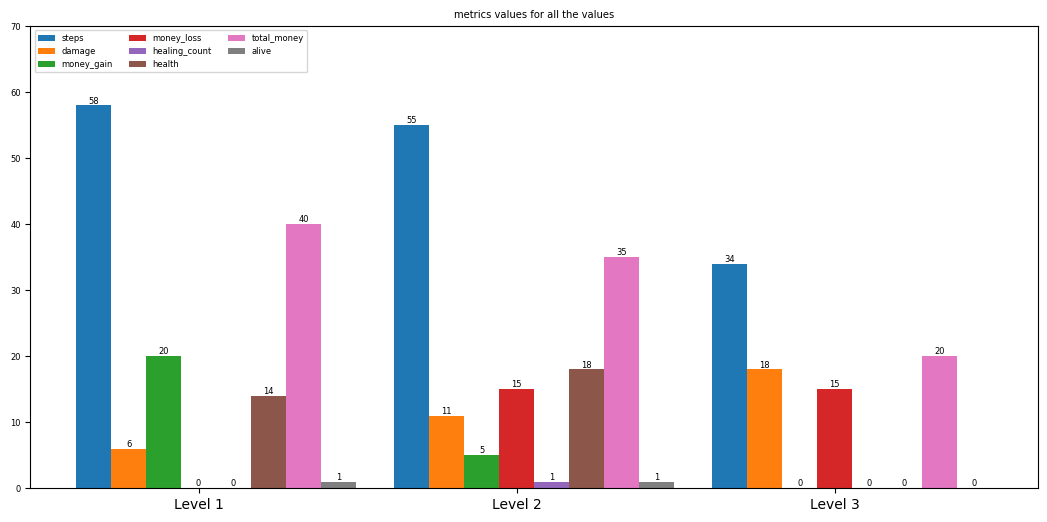

In [116]:
def plot_all_metrics(all_metrics):
    metrics=all_metrics[0].keys()
    fig,ax = plt.subplots(figsize=(13,6))
    chart_metrics=dict()
    for m in metrics:
        chart_metrics[m]=tuple(map(lambda x:x[m],all_metrics))

    width= 0.11
    group=0
    print(plt.rcParams['font.size'])
    plt.rcParams['font.size']=6

    
    x_pos= np.arange(len(all_metrics))
    for metric,values in chart_metrics.items():
        offset=x_pos+group*width
        rects= ax.bar(offset, list(map(lambda v:round(v,2),values)), width, label=metric,align='center')
        ax.bar_label(rects)
        group+=1
    ax.set_ylabel('')
    ax.set_title('metrics values for all the values')

    x_pos=x_pos+(len(all_metrics)*width)

    ax.set_xticks(x_pos, [f"Level {int(i+1)}" for i in x_pos],fontsize=10)
    ax.legend(loc='upper left', ncols=len(all_metrics))
    ax.set_ylim(0, 70)

    plt.show()
plot_all_metrics(data[5])

82 simulations have been done, the agent lasted for 2.341463414634146 levels on average, with a max of 5 and a minimum of 1
6.0


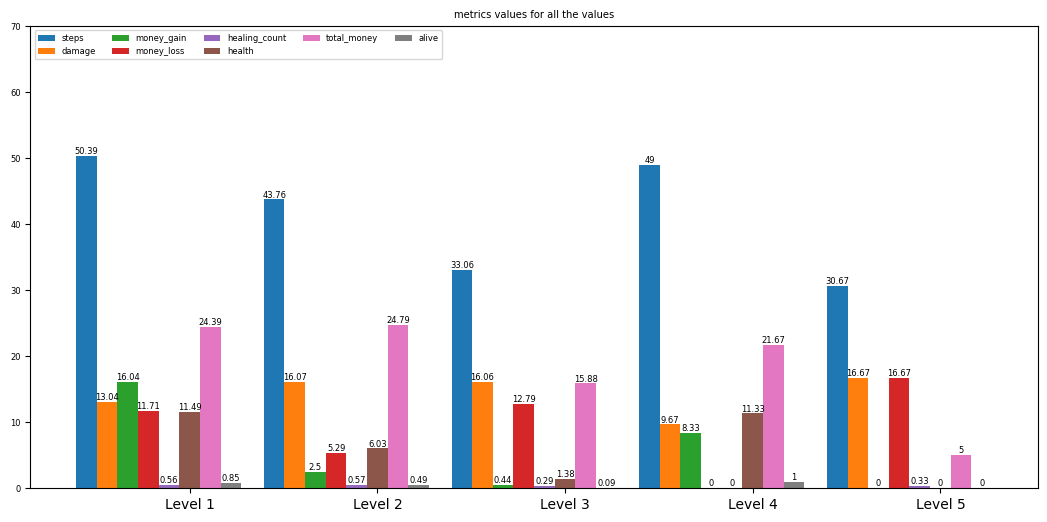

[{'steps': 50.390243902439025,
  'damage': 13.036585365853659,
  'money_gain': 16.036585365853657,
  'money_loss': 11.707317073170731,
  'healing_count': 0.5609756097560976,
  'health': 11.487804878048781,
  'total_money': 24.390243902439025,
  'alive': 0.8536585365853658},
 {'steps': 43.75714285714286,
  'damage': 16.071428571428573,
  'money_gain': 2.5,
  'money_loss': 5.285714285714286,
  'healing_count': 0.5714285714285714,
  'health': 6.0285714285714285,
  'total_money': 24.785714285714285,
  'alive': 0.4857142857142857},
 {'steps': 33.05882352941177,
  'damage': 16.058823529411764,
  'money_gain': 0.4411764705882353,
  'money_loss': 12.794117647058824,
  'healing_count': 0.29411764705882354,
  'health': 1.3823529411764706,
  'total_money': 15.882352941176471,
  'alive': 0.08823529411764706},
 {'steps': 49.0,
  'damage': 9.666666666666666,
  'money_gain': 8.333333333333334,
  'money_loss': 0.0,
  'healing_count': 0.0,
  'health': 11.333333333333334,
  'total_money': 21.66666666666

In [117]:
average_duration=sum(map(len,data))/len(data)
max_duration=max(map(len,data))
min_duration=min(map(len,data))

print(f"{len(data)} simulations have been done, the agent lasted for {average_duration} levels on average, with a max of {max_duration} and a minimum of {min_duration}")

def levels_avg_metrics(simulations):
    max_duration=max(map(len,simulations))
    level_groups=[]
    #group levels by their number
    for i in range(max_duration):
        avg_metric=[]
        for s in simulations:
            if len(s) > i: avg_metric.append(s[i])
        level_groups.append(avg_metric)
    result=[]
    keys=level_groups[0][0].keys()
    #for each group of levels calculate the average on each metric
    for lvl in level_groups:
        avg=dict()
        for k in keys: avg[k]=0

        for m in lvl:
            for k in m.keys():
                avg[k]+=m[k]
        
        for k in keys: avg[k]/=len(lvl)
        #store the result for the current level group
        result.append(avg)
    return result

plot_all_metrics(levels_avg_metrics(data))

levels_avg_metrics(data)

In [ ]:
#compara percentuali di successo dei due agente (ricorda motliplica risultate fra la colonne)
def plot_agents_difference(old_agent,new_agent):
    pass

